In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import matplotlib.pyplot as plt
import math
import os
from omegaconf import OmegaConf

import torch
from torch_geometric.utils import to_dense_adj
import torchvision.transforms as T
from fsspec.core import url_to_fs
from hydra.utils import instantiate
from trainer.data.util import AddCanvasElement, AddRelationConstraints, sparse_to_dense
from trainer.global_configs import DATASET_DIR, JOB_DIR
from trainer.helpers.layout_tokenizer import LayoutSequenceTokenizer
from trainer.helpers.sampling import SAMPLING_CONFIG_DICT
from trainer.helpers.task import get_cond, filter_canvas
from trainer.helpers.visualization import save_gif, save_image, save_label, save_label_with_size, save_relation
from trainer.hydra_configs import TestConfig

SIZE = (360, 240)

# user tunable parameters
# cond_type, W_CANVAS = "relation", True  # uncomment this line if you want to try relation task
cond_type, W_CANVAS = "cwh", False  # choices: unconditional, c, cwh, partial, refinement
n_samples = 4  # num. of samples to generate at once
target_index = 0  # index of real data, partial fields in it are used for conditional generation

job_dir = os.path.join(JOB_DIR, "layoutdm_publaynet/0")

config_path = os.path.join(job_dir, "config.yaml")
fs, _ = url_to_fs(config_path)
if fs.exists(config_path):
    with fs.open(config_path, "rb") as file_obj:
        train_cfg = OmegaConf.load(file_obj)
else:
    raise FileNotFoundError
train_cfg.dataset.dir = DATASET_DIR

test_cfg = OmegaConf.structured(TestConfig)
test_cfg.cond = cond_type
device = "cuda" if torch.cuda.is_available() else "cpu"

sampling_cfg = OmegaConf.structured(SAMPLING_CONFIG_DICT[test_cfg.sampling])  # NOTE: you may change sampling algorithm
OmegaConf.set_struct(sampling_cfg, False)

/home/maciejkozubal/miniconda3/envs/layout-dm/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maciejkozubal/miniconda3/envs/layout-dm/lib/python3.7/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/maciejkozubal/miniconda3/envs/layout-dm/lib/python3.7/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/maciejkozubal/minic

In [10]:
# initialize data and model
tokenizer = LayoutSequenceTokenizer(
    data_cfg=train_cfg.data, dataset_cfg=train_cfg.dataset
)
model = instantiate(train_cfg.model)(
    backbone_cfg=train_cfg.backbone, tokenizer=tokenizer
).to(device)
model_path = os.path.join(job_dir, "best_model.pt")
with fs.open(model_path, "rb") as file_obj:
    model.load_state_dict(torch.load(file_obj, map_location=torch.device('cpu')))
model = model.to(device)
model.eval()
sampling_cfg = model.aggregate_sampling_settings(sampling_cfg, test_cfg)

if W_CANVAS:
    # add canvas and shift label id to load relation gts
    assert cond_type == "relation"
    transform = T.Compose([
        AddCanvasElement(),
        AddRelationConstraints(edge_ratio=0.1),
    ])
else:
    assert cond_type != "relation"
    transform = None
dataset = instantiate(train_cfg.dataset)(split="test", transform=transform)
save_kwargs = {
    "colors": dataset.colors, "names": dataset.labels,
    "canvas_size": SIZE, "use_grid": True,
    # "draw_label": True,
}


### Real data visualization

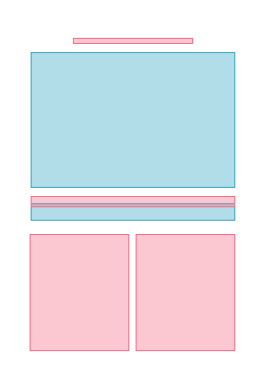

In [11]:
# load target data and visualize GT
bbox, label, _, mask = sparse_to_dense(dataset[target_index])
gt_cond = model.tokenizer.encode(
    {"label": label, "mask": mask, "bbox": bbox}
)
if "bos" in tokenizer.special_tokens:
    gt = model.tokenizer.decode(gt_cond["seq"][:, 1:])
else:
    gt = model.tokenizer.decode(gt_cond["seq"])
if W_CANVAS:
    gt = filter_canvas(gt)  # remove canvas attributes before visualization
plt.axis("off")
plt.imshow(save_image(gt["bbox"], gt["label"], gt["mask"], **save_kwargs))

### Unconditional Generation

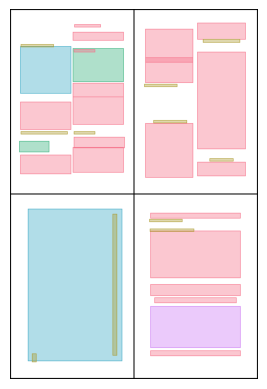

In [12]:
# MK
cond_type = "unconditional"

assert cond_type == "unconditional"
pred = model.sample(batch_size=n_samples, cond=None, sampling_cfg=sampling_cfg)
plt.axis("off")
plt.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs))

### Conditional Generation

#### Prediction

In [13]:
# MK
cond_type = "c"

cond = get_cond(
    batch=dataset[target_index],
    tokenizer=model.tokenizer,
    cond_type=cond_type,
    model_type=type(model),#.__name__, # is __name__ correct? 
)
pred = model.sample(batch_size=n_samples, cond=cond, sampling_cfg=sampling_cfg)

#### Visualization of conditional inputs

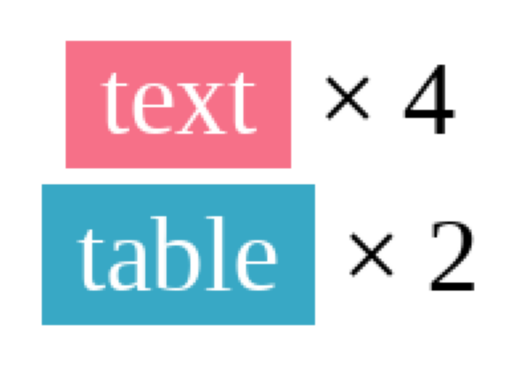

In [15]:
plt.axis("off")
input_ = model.tokenizer.decode(cond["seq"].cpu())
mask = pred["mask"][0]
label, bbox = pred["label"][0][mask], pred["bbox"][0][mask]
if cond_type == "c":
    plt.imshow(save_label(label, **save_kwargs))
elif cond_type == "cwh":
    plt.imshow(save_label_with_size(label, bbox, **save_kwargs))
elif cond_type == "relation":
    data = cond["batch_w_canvas"]
    edge_attr = to_dense_adj(data.edge_index, data.batch, data.edge_attr)
    plt.imshow(save_relation(label_with_canvas=data.y.cpu(), edge_attr=edge_attr.cpu()[0], **save_kwargs))
elif cond_type  == "partial":
    plt.imshow(save_image(input_["bbox"], input_["label"], input_["mask"], **save_kwargs))
elif cond_type == "refinement":
    noisy_input = model.tokenizer.decode(cond["seq_orig"].cpu())
    plt.imshow(save_image(noisy_input["bbox"][0:1], noisy_input["label"][0:1], noisy_input["mask"][0:1], **save_kwargs))


#### Visualization of outputs

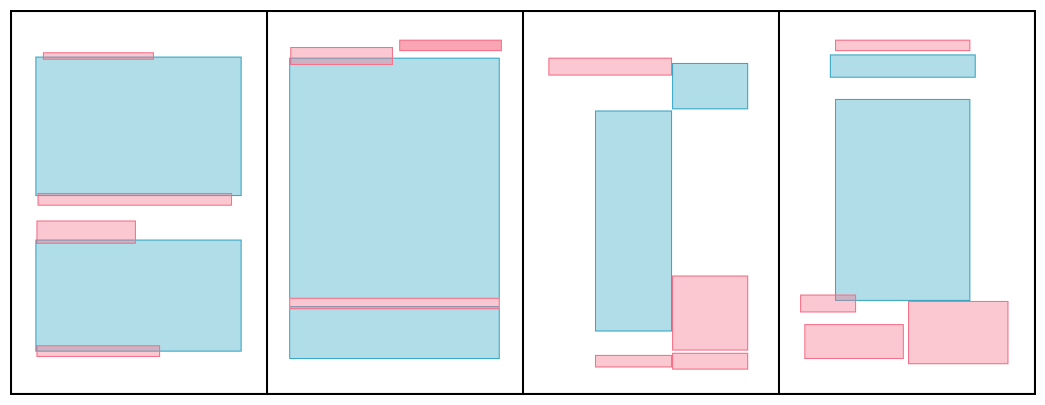

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_axis_off()
ax.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs, nrow=int(math.sqrt(n_samples) * 2)))

#### Make GIF for Unconditional Generation

In [19]:
new_save_kwargs = copy.deepcopy(save_kwargs)
new_save_kwargs.pop("use_grid")
ids_list = model.model.sample(
    batch_size=4,
    sampling_cfg=sampling_cfg,
    get_intermediate_results=True,
)
images = []
for ids in ids_list:
    layouts = model.tokenizer.decode(ids)
    image = save_image(
        layouts["bbox"],
        layouts["label"],
        layouts["mask"],
        **new_save_kwargs
    )
    images.append(image)
N_step = len(images)
images = images[int(0.5*N_step):]
save_gif(images, "../tmp/animation/{}.gif")


#### Dump colors of all labels

{'colors': [(246, 112, 136), (173, 156, 49), (51, 176, 122), (56, 168, 197), (204, 121, 244)], 'names': ['text', 'title', 'list', 'table', 'figure'], 'canvas_size': (360, 240), 'use_grid': True}


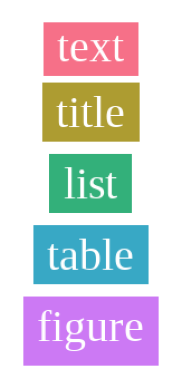

In [20]:
labels = []
for i, name in enumerate(save_kwargs["names"]):
    if "_cutout" in name:
        continue
    else:
        labels.append(i)
        
print(save_kwargs)
plt.axis("off")
plt.imshow(save_label(labels, **save_kwargs))

# Tests

## Approach 1

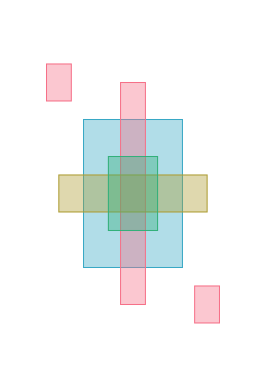

In [23]:
# synthetic data
test_bbox = torch.tensor([[
    [0.5, 0.5, 0.1, 0.6],
    [0.5, 0.5, 0.6, 0.1],
    [0.5, 0.5, 0.2, 0.2],
    [0.5, 0.5, 0.4, 0.4],
    [0.8, 0.8, 0.1, 0.1],
    [0.2, 0.2, 0.1, 0.1]]])
test_label = torch.tensor([
    [0, 1, 2, 3, 0, 0]])
test_mask = torch.tensor([
    [True, True, True, True, True, True]])
test_gt = dict({'bbox': test_bbox, 'label': test_label, 'mask': test_mask})

# load target data and visualize GT
#bbox, label, _, mask = sparse_to_dense(dataset[target_index])
gt_cond = model.tokenizer.encode(
    {"label": test_label, "mask": test_mask, "bbox": test_bbox}
)

if "bos" in tokenizer.special_tokens:
    gt = model.tokenizer.decode(gt_cond["seq"][:, 1:])
else:
    gt = model.tokenizer.decode(gt_cond["seq"])
if W_CANVAS:
    gt = filter_canvas(gt)  # remove canvas attributes before visualization
plt.axis("off")
plt.imshow(save_image(test_gt["bbox"], test_gt["label"], test_gt["mask"], **save_kwargs))

In [24]:
def test_cond(cond):
    # pred
    pred = model.sample(batch_size=n_samples, cond=cond, sampling_cfg=sampling_cfg)

    # show elements
    plt.axis("off")
    input_ = model.tokenizer.decode(cond["seq"].cpu())
    mask = pred["mask"][0]
    label, bbox = pred["label"][0][mask], pred["bbox"][0][mask]
    if cond_type == "c":
        plt.imshow(save_label(label, **save_kwargs))
    elif cond_type == "cwh":
        plt.imshow(save_label_with_size(label, bbox, **save_kwargs))
    elif cond_type == "relation":
        data = cond["batch_w_canvas"]
        edge_attr = to_dense_adj(data.edge_index, data.batch, data.edge_attr)
        plt.imshow(save_relation(label_with_canvas=data.y.cpu(), edge_attr=edge_attr.cpu()[0], **save_kwargs))
    elif cond_type  == "partial":
        plt.imshow(save_image(input_["bbox"], input_["label"], input_["mask"], **save_kwargs))
    elif cond_type == "refinement":
        noisy_input = model.tokenizer.decode(cond["seq_orig"].cpu())
        plt.imshow(save_image(noisy_input["bbox"][0:1], noisy_input["label"][0:1], noisy_input["mask"][0:1], **save_kwargs))

    # plot
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_axis_off()
    ax.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs, nrow=int(math.sqrt(n_samples) * 2)))

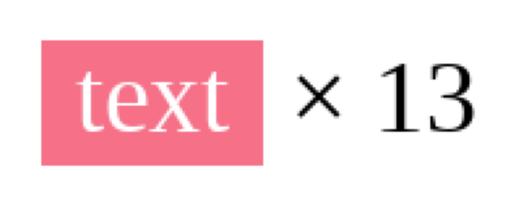

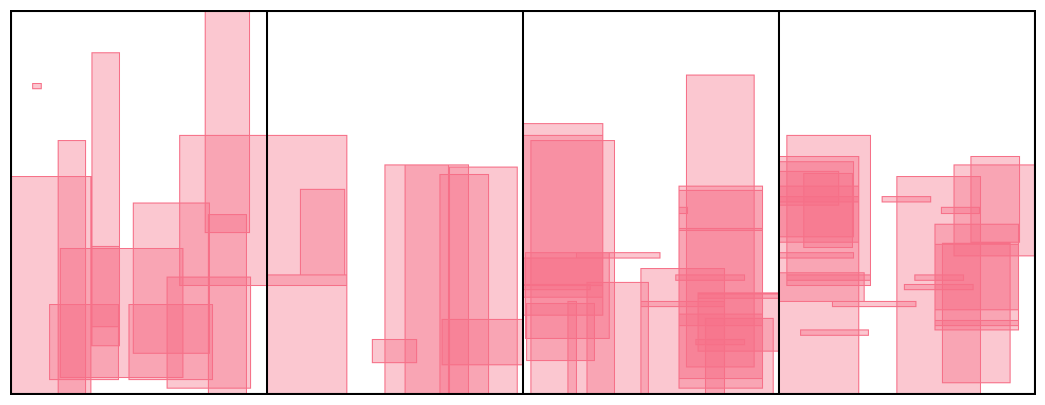

In [25]:
cond1 = dict({
  'seq': torch.tensor([
    [0, 134, 134, 134, 134, 0],
    [0, 134, 134, 134, 134, 0],
    [0, 134, 134, 134, 134, 0],
    [0, 134, 134, 134, 134, 0]
  ]),
  'mask': torch.tensor([
    [True, True, True, True, True, True],
    [True, True, True, True, True, True],
    [True, True, True, True, True, True],
    [True, True, True, True, True, True]
  ]),
  'type': 'c',
  'num_element': torch.tensor([6, 6, 6, 6])
})

cond2 =  {
    "seq": torch.tensor([[1, 2, 3]]),  
    "seq_orig": torch.tensor([[1, 2, 3]]),  
    "batch_w_canvas": None,  
}

cond3 = dict({
  'seq': torch.tensor([
    [0, 0, 130, 130, 0, 0, 130, 130, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 130, 130, 130, 130, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [20, 20, 20, 20, 20, 20, 20, 20, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [20, 20, 20, 20, 20, 20, 20, 20, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    
  ]),
  'mask': torch.tensor([
    [ True, True, True, True, True, True, True, True, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False],
    [ True, True, True, True, True, True, True, True, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False],
    [ True, True, True, True, True, True, True, True, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False],
    [ True, True, True, True, True, True, True, True, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False]
  ]),
  'type': 'c',
  'num_element': torch.tensor([6, 6, 6, 6])
})

cond4 = dict({
  'seq': torch.tensor([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    
  ]),
  'mask': torch.tensor([
    [ False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False],
    [ False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False],
    [ False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False],
    [ False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False, False, False, False, False,  False, False, False, False, False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False,  False,  False,  False,  False,  False,
    False,  False,  False,  False,  False]
  ]),
  'type': 'c',
  'num_element': torch.tensor([6, 6, 6, 6])
})

test_cond(cond3)

## Approach 2

### cond_type = "cwh"

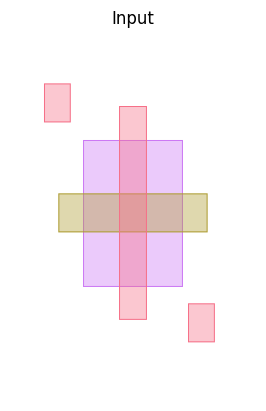

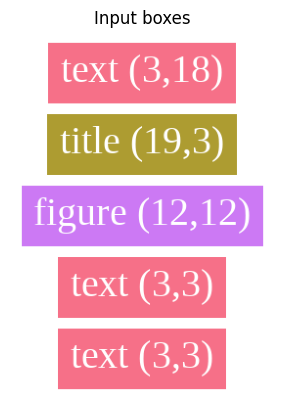

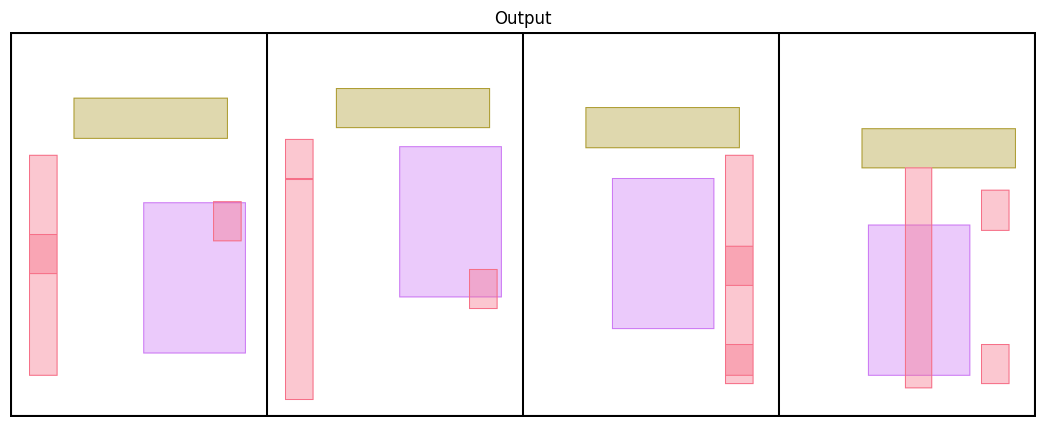

In [26]:
# Custom dataset
from torch_geometric.data import Data
## [xc, yc, w, h] format in 0~1 normalized coordinates
bboxes = torch.FloatTensor([
    [0.5, 0.5, 0.1, 0.6],
    [0.5, 0.5, 0.6, 0.1],
    [0.5, 0.5, 0.2, 0.2],
    [0.5, 0.5, 0.4, 0.4],
    [0.8, 0.8, 0.1, 0.1],
    [0.2, 0.2, 0.1, 0.1]
])
## see .labels of each dataset class for name-index correspondense
labels = torch.LongTensor([0, 1, 6, 4, 0, 0])
assert bboxes.size(0) == labels.size(0) and bboxes.size(1) == 4
## set some optional attributes by a dummy value (False)
attr = {k: torch.full((1,), fill_value=False) for k in ["filtered", "has_canvas_element", "NoiseAdded"]}
data = Data(x=bboxes, y=labels, attr=attr)  # can be used as an alternative for `dataset[target_index]` in demo.ipynb

# Real data visualization
## load target data and visualize GT
bbox, label, _, mask = sparse_to_dense(data)
gt_cond = model.tokenizer.encode(
    {"label": label, "mask": mask, "bbox": bbox}
)
if "bos" in tokenizer.special_tokens:
    gt = model.tokenizer.decode(gt_cond["seq"][:, 1:])
else:
    gt = model.tokenizer.decode(gt_cond["seq"])
if W_CANVAS:
    gt = filter_canvas(gt)  # remove canvas attributes before visualization
plt.axis("off")
img_input = save_image(gt["bbox"], gt["label"], gt["mask"], **save_kwargs) 
plt.imshow(img_input)
plt.title('Input')
plt.show()

# Conditional Generation
## Prediction
cond_type = "cwh"
cond = get_cond(
    batch=data,
    tokenizer=model.tokenizer,
    cond_type=cond_type,
    model_type=type(model),#.__name__, # is __name__ correct? 
)
pred = model.sample(batch_size=n_samples, cond=cond, sampling_cfg=sampling_cfg)

## Visualization of conditional inputs
plt.axis("off")
input_ = model.tokenizer.decode(cond["seq"].cpu())
mask = pred["mask"][0]
label, bbox = pred["label"][0][mask], pred["bbox"][0][mask]
if cond_type == "c":
    img_input_boxes = save_label(label, **save_kwargs)
elif cond_type == "cwh":
    img_input_boxes = save_label_with_size(label, bbox, **save_kwargs)
elif cond_type == "relation":
    data = cond["batch_w_canvas"]
    edge_attr = to_dense_adj(data.edge_index, data.batch, data.edge_attr)
    img_input_boxes = save_relation(label_with_canvas=data.y.cpu(), edge_attr=edge_attr.cpu()[0], **save_kwargs)
elif cond_type  == "partial":
    img_input_boxes = save_image(input_["bbox"], input_["label"], input_["mask"], **save_kwargs)
elif cond_type == "refinement":
    noisy_input = model.tokenizer.decode(cond["seq_orig"].cpu())
    img_input_boxes = save_image(noisy_input["bbox"][0:1], noisy_input["label"][0:1], noisy_input["mask"][0:1], **save_kwargs)
plt.imshow(img_input_boxes)
plt.title('Input boxes')
plt.show()

## Visualization of outputs
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_axis_off()
ax.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs, nrow=int(math.sqrt(n_samples) * 2)))
plt.title('Output')
plt.show()

### cond_type = "c"

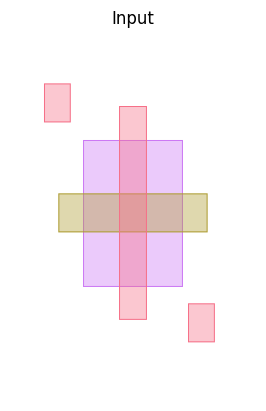

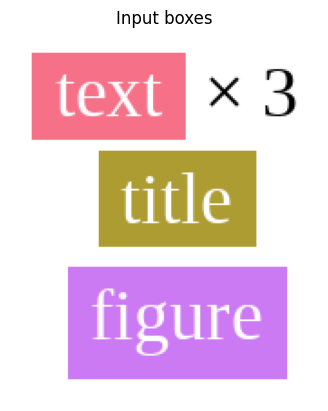

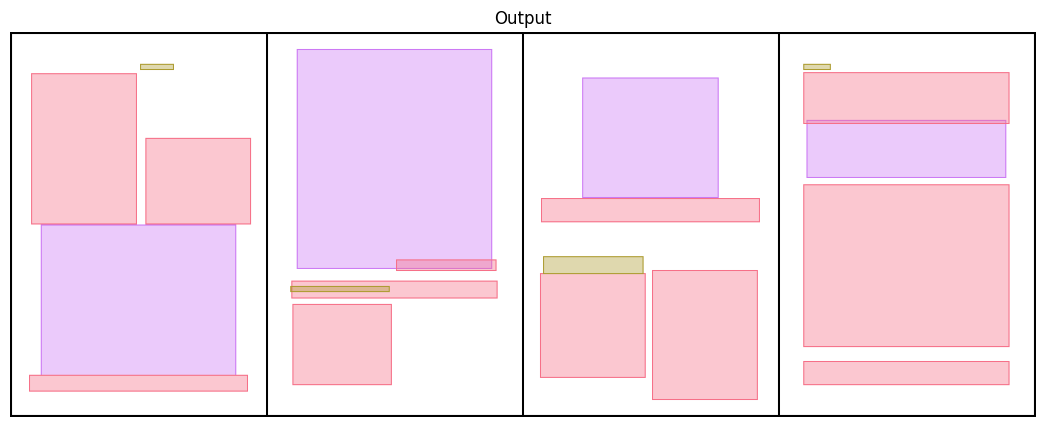

In [27]:
# Custom dataset
from torch_geometric.data import Data
## [xc, yc, w, h] format in 0~1 normalized coordinates
bboxes = torch.FloatTensor([
    [0.5, 0.5, 0.1, 0.6],
    [0.5, 0.5, 0.6, 0.1],
    [0.5, 0.5, 0.2, 0.2],
    [0.5, 0.5, 0.4, 0.4],
    [0.8, 0.8, 0.1, 0.1],
    [0.2, 0.2, 0.1, 0.1]
])
## see .labels of each dataset class for name-index correspondense
labels = torch.LongTensor([0, 1, 6, 4, 0, 0])
assert bboxes.size(0) == labels.size(0) and bboxes.size(1) == 4
## set some optional attributes by a dummy value (False)
attr = {k: torch.full((1,), fill_value=False) for k in ["filtered", "has_canvas_element", "NoiseAdded"]}
data = Data(x=bboxes, y=labels, attr=attr)  # can be used as an alternative for `dataset[target_index]` in demo.ipynb

# Real data visualization
## load target data and visualize GT
bbox, label, _, mask = sparse_to_dense(data)
gt_cond = model.tokenizer.encode(
    {"label": label, "mask": mask, "bbox": bbox}
)
if "bos" in tokenizer.special_tokens:
    gt = model.tokenizer.decode(gt_cond["seq"][:, 1:])
else:
    gt = model.tokenizer.decode(gt_cond["seq"])
if W_CANVAS:
    gt = filter_canvas(gt)  # remove canvas attributes before visualization
plt.axis("off")
img_input = save_image(gt["bbox"], gt["label"], gt["mask"], **save_kwargs) 
plt.imshow(img_input)
plt.title('Input')
plt.show()

# Conditional Generation
## Prediction
cond_type = "c"
cond = get_cond(
    batch=data,
    tokenizer=model.tokenizer,
    cond_type=cond_type,
    model_type=type(model),#.__name__, # is __name__ correct? 
)
pred = model.sample(batch_size=n_samples, cond=cond, sampling_cfg=sampling_cfg)

## Visualization of conditional inputs
plt.axis("off")
input_ = model.tokenizer.decode(cond["seq"].cpu())
mask = pred["mask"][0]
label, bbox = pred["label"][0][mask], pred["bbox"][0][mask]
if cond_type == "c":
    img_input_boxes = save_label(label, **save_kwargs)
elif cond_type == "cwh":
    img_input_boxes = save_label_with_size(label, bbox, **save_kwargs)
elif cond_type == "relation":
    data = cond["batch_w_canvas"]
    edge_attr = to_dense_adj(data.edge_index, data.batch, data.edge_attr)
    img_input_boxes = save_relation(label_with_canvas=data.y.cpu(), edge_attr=edge_attr.cpu()[0], **save_kwargs)
elif cond_type  == "partial":
    img_input_boxes = save_image(input_["bbox"], input_["label"], input_["mask"], **save_kwargs)
elif cond_type == "refinement":
    noisy_input = model.tokenizer.decode(cond["seq_orig"].cpu())
    img_input_boxes = save_image(noisy_input["bbox"][0:1], noisy_input["label"][0:1], noisy_input["mask"][0:1], **save_kwargs)
plt.imshow(img_input_boxes)
plt.title('Input boxes')
plt.show()

## Visualization of outputs
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_axis_off()
ax.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs, nrow=int(math.sqrt(n_samples) * 2)))
plt.title('Output')
plt.show()

In [28]:
pred['bbox'][0]

tensor([[0.5000, 0.9194, 0.8634, 0.0441],
        [0.5728, 0.0871, 0.1284, 0.0142],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.6993, 0.7663, 0.3958],
        [0.7363, 0.3863, 0.4161, 0.2263],
        [0.2842, 0.3014, 0.4161, 0.3958],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0

In [29]:
pred['label'][0]

tensor([0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])